In [65]:
# import Pkg
# Pkg.add("DifferentialEquations")
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("ModelingToolkit")
# Pkg.add("LSODA")
# Pkg.add("BenchmarkTools")
# Pkg.add("DataFrames")
# Pkg.add("CSV")

In [114]:
using DifferentialEquations
using Plots
using DataFrames, CSV
using Sundials, LSODA
using BenchmarkTools

In [98]:
dirname_model = "../src/model_ctypes/ina_pipette/"

filename_legend_constants = Base.Filesystem.joinpath(dirname_model, "legend_constants.csv")
filename_legend_states = Base.Filesystem.joinpath(dirname_model, "legend_states.csv");

In [99]:
legend_states = DataFrame(CSV.File(filename_legend_states))
legend_constants = DataFrame(CSV.File(filename_legend_constants))

,name,value,bound_1,bound_2
,String,Float64,Float64,Float64
1,c_p,4.50296e-12,1.0e-14,5.0e-12
2,c_m,2.47302e-11,1.0e-11,9.0e-11
3,a0_m,2736.96,1000.0,10000.0
4,b0_m,71.359,10.0,100.0
5,delta_m,20.6157,10.0,100.0
6,s_m,9.30608,1.0,10.0
7,a0_h,0.460405,0.1,1.0
8,b0_h,503.808,100.0,1000.0
9,delta_h,15.2348,10.0,100.0


In [100]:
p = collect(zip(Symbol.(legend_constants[!, :name]),
                legend_constants[!, :value]))
p = NamedTuple(p)

(c_p = 4.502963e-12, c_m = 2.473016e-11, a0_m = 2736.956, b0_m = 71.35904, delta_m = 20.6157, s_m = 9.306083, a0_h = 0.4604052, b0_h = 503.8082, delta_h = 15.2348, s_h = 21.96405, a0_j = 0.4475461, b0_j = 20613.33, delta_j = 4.115303, s_j = 167.3159, tau_j_const = 0.0007794313, R = 2.494677e7, R_f = 326421.4, g_max = 439220.4, g_leak = 0.4812443, tau_z = 0.000100034, v_half_m = 24.35802, v_half_h = 59.69117, k_m = 5.66677, k_h = 5.507771, x_c_comp = 0.09929933, x_r_comp = 1.02, alpha = 0.75, v_off = -2.0, v_rev = 18.0, v_c = -80.0)

In [106]:
function compute_algebraic(du, u, p, t)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
    
    tau_m = 1 / (p.a0_m * exp(v_m / p.s_m) + p.b0_m * exp(-v_m / p.delta_m))
    tau_h = 1 / (p.a0_h * exp(-v_m / p.s_h) + p.b0_h * exp(v_m / p.delta_h))
    tau_j = p.tau_j_const + 1 / (p.a0_j * exp(-v_m / p.s_j) + p.b0_j * exp(v_m / p.delta_j))
    
    m_inf = 1 / (1 + exp(-(p.v_half_m + v_m) / p.k_m))
    h_inf = 1 / (1 + exp((p.v_half_h + v_m) / p.k_h))
    
    v_cp = p.v_c + (p.v_c - v_comp) * (1 / (1 - p.alpha) - 1)

    I_leak = p.g_leak * v_m
    I_Na = p.g_max * h * m^3 * j * (v_m - p.v_rev)
    I_c = 1e9 * p.c_m * ((v_p + p.v_off - v_m) / (p.R * p.c_m) - 1e-9 * (I_leak + I_Na) / p.c_m)
    I_p = 1e9 * p.c_p * (v_cp - v_p)/(p.c_p * p.R_f)
    I_comp = 1e9 * p.x_c_comp * p.c_m * (p.v_c - v_comp) / (p.x_c_comp * p.c_m * p.x_r_comp * p.R * (1 - p.alpha))
    I_in = I_leak + I_Na + I_c  + I_p - I_comp
    
    a = (tau_m=tau_m, tau_h=tau_h, tau_j=tau_j,
         m_inf=m_inf, h_inf=h_inf,
         v_cp=v_cp, I_leak=I_leak, I_Na=I_Na, I_c=I_c, I_p=I_p, I_comp=I_comp, I_in=I_in)
    
    return a
end

compute_algebraic (generic function with 1 method)

In [108]:
function compute_rates!(du, u, p, t)
        
    v_comp, v_p, v_m, m, h, j, I_out = u
    a = compute_algebraic(du, u, p, t)
    
    du[1] = (p.v_c - v_comp) / (p.x_c_comp * p.c_m * p.x_r_comp * p.R * (1 - p.alpha))  # v_comp
    du[2] = (a.v_cp - v_p) / (p.c_p * p.R_f)  # v_p
    du[3] = (v_p + p.v_off - v_m) / (p.R * p.c_m) - (1e-9) * (a.I_leak + a.I_Na) / p.c_m  # v_m
        
    du[4] = (a.m_inf - m) / a.tau_m  # m
    du[5] = (a.h_inf - h) / a.tau_h  # h
    du[6] = (a.h_inf - j) / a.tau_j  # j
        
    du[7] = (a.I_in - I_out) / p.tau_z  # I_out
    
    nothing
end

compute_rates! (generic function with 1 method)

In [109]:
u₀ = [-80.0, -80.0, -80.0, 0.0, 1.0, 1.0, 0.0]
# u₀ = [-10.0, -80.0, -80.0, 0.0, 1.0, 1.0, 0.0]
du = zero(u₀)
tspan = (0.0, 0.001)  # sec

(0.0, 0.001)

In [110]:
a = compute_algebraic(nothing, u₀, p, 0)

(tau_m = 0.0002891954144328234, tau_h = 0.04945823981339022, tau_j = 1.3858279938382658, m_inf = 5.4405337356056934e-5, h_inf = 0.9755722566332293, v_cp = -80.0, I_leak = -38.499544, I_Na = -0.0, I_c = -41.67115545327591, I_p = 0.0, I_comp = 0.0, I_in = -80.17069945327592)

In [111]:
compute_rates!(du, u₀, p, 0)

In [112]:
du

7-element Vector{Float64}:
       0.0
       0.0
   -1685.0337989433108
       0.18812655609618814
      -0.49390644428387354
      -0.01762682199766671
 -801434.506800447

In [115]:
prob = ODEProblem(compute_rates!, u₀, tspan, p);

In [116]:
alg = CVODE_BDF()
sol = solve(prob, alg=alg);

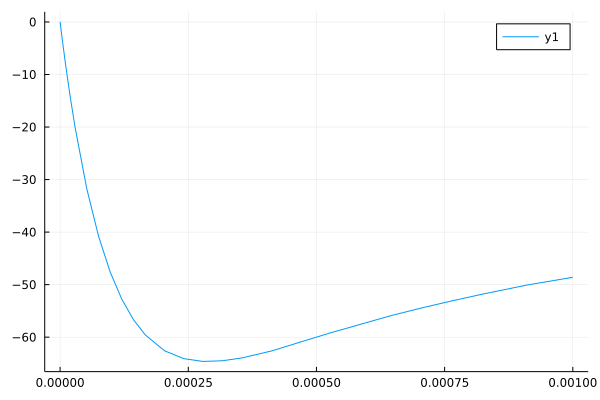

In [117]:
plot(sol.t, sol[end, :])